In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

# data_cutoff_date = '20230508'
data_cutoff_date = '20230619'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"
# slope relative local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit.parquet"
# seemingly local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")))

9591120
9568944
9591120


# Open data

## SOS

In [4]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds

tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:data_cutoff_date].reset_index()

In [5]:
tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='SF_avg_1m_ue'").sort_values('value').dropna()


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3672508420.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='SF_avg_1m_ue'").sort_values('value').dropna()


,time,variable,value,height,tower,measurement
1207204,2022-11-30 00:30:00,SF_avg_1m_ue,0.000000,1.0,ue,snow flux
5695183,2023-03-18 04:00:00,SF_avg_1m_ue,0.000000,1.0,ue,snow flux
5694392,2023-03-18 03:30:00,SF_avg_1m_ue,0.000000,1.0,ue,snow flux
5693720,2023-03-18 03:00:00,SF_avg_1m_ue,0.000000,1.0,ue,snow flux
5693147,2023-03-18 02:30:00,SF_avg_1m_ue,0.000000,1.0,ue,snow flux
...,...,...,...,...,...,...
2130766,2022-12-22 06:30:00,SF_avg_1m_ue,29.500000,1.0,ue,snow flux
2126397,2022-12-22 04:00:00,SF_avg_1m_ue,38.524998,1.0,ue,snow flux
2124878,2022-12-22 03:00:00,SF_avg_1m_ue,38.526665,1.0,ue,snow flux
2128828,2022-12-22 05:30:00,SF_avg_1m_ue,47.820000,1.0,ue,snow flux


In [6]:
tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='SF_avg_1m_ue'").value.mean()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3926207701.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='SF_avg_1m_ue'").value.mean()


0.06840158895801407

In [7]:
tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='spd_3m_c'").sort_values('value').dropna()


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1892060599.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='spd_3m_c'").sort_values('value').dropna()


,time,variable,value,height,tower,measurement
4991970,2023-03-01 04:30:00,spd_3m_c,0.248394,3.0,c,wind speed
2612402,2023-01-02 21:00:00,spd_3m_c,0.302061,3.0,c,wind speed
5782711,2023-03-20 06:30:00,spd_3m_c,0.304443,3.0,c,wind speed
7194517,2023-04-23 06:30:00,spd_3m_c,0.319392,3.0,c,wind speed
7284960,2023-04-25 10:30:00,spd_3m_c,0.325872,3.0,c,wind speed
...,...,...,...,...,...,...
2125695,2022-12-22 03:30:00,spd_3m_c,12.641580,3.0,c,wind speed
2132531,2022-12-22 07:30:00,spd_3m_c,13.080628,3.0,c,wind speed
2129734,2022-12-22 06:00:00,spd_3m_c,13.298707,3.0,c,wind speed
2132052,2022-12-22 07:00:00,spd_3m_c,13.830691,3.0,c,wind speed


In [8]:
tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='spd_3m_c'").value.mean()

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/4058977642.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df[tidy_df.time > '20221130'][tidy_df.time < '20230509'].query("variable =='spd_3m_c'").value.mean()


2.8468423428053993

## SPLASH

In [9]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

snowdepth_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')

100%|██████████| 646/646 [00:35<00:00, 18.21it/s]


# Create categories

In [98]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/swifter/swifter.py:223: UserWarning: registration of accessor <class 'swifter.swifter.SeriesAccessor'> under name 'swifter' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_series_accessor("swifter")
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/swifter/swifter.py:332: UserWarning: registration of accessor <class 'swifter.swifter.DataFrameAccessor'> under name 'swifter' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("swifter")


## Calibrate SOS gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [10]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [11]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [12]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.524665,2.487664,0.037000
1,h2o_10m_d,d,10.0,1.777192,2.487664,-0.710472
2,h2o_10m_ue,ue,10.0,1.466298,2.487664,-1.021366
3,h2o_10m_uw,uw,10.0,2.096407,2.487664,-0.391257
4,h2o_15m_c,c,15.0,2.289604,2.466423,-0.176820
5,h2o_1m_c,c,1.0,2.840210,2.644168,0.196042
6,h2o_1m_d,d,1.0,2.035098,2.644168,-0.609070
7,h2o_1m_ue,ue,1.0,2.150399,2.644168,-0.493769
8,h2o_1m_uw,uw,1.0,2.425554,2.644168,-0.218614
9,h2o_20m_c,c,20.0,1.255368,2.452797,-1.197429


Update dataset with corrections

In [13]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
77,2022-11-01 00:00:00,h2o_3m_ue,2.575798,3.0,ue,Water vapor density
104,2022-11-01 00:00:00,h2o_10m_d,1.920190,10.0,d,Water vapor density
289,2022-11-01 00:00:00,h2o_1m_d,2.311011,1.0,d,Water vapor density
320,2022-11-01 00:00:00,h2o_10m_uw,2.390329,10.0,uw,Water vapor density
478,2022-11-01 00:00:00,h2o_1m_ue,2.032952,1.0,ue,Water vapor density
...,...,...,...,...,...,...
9580274,2023-06-19 17:30:00,h2o_3m_d,3.101750,3.0,d,Water vapor density
9580296,2023-06-19 17:30:00,h2o_10m_d,2.669686,10.0,d,Water vapor density
9580306,2023-06-19 17:30:00,h2o_3m_c,2.461334,3.0,c,Water vapor density
9580408,2023-06-19 17:30:00,h2o_1m_uw,3.362670,1.0,uw,Water vapor density


In [14]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [15]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [16]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [17]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [18]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.VConcatChart(...)

### With monthly means

In [19]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [20]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [21]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [22]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [23]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [24]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# # hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# # irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [25]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## If we want to, we can convert instrument locations to streamwise coordinates too

In [26]:
# for height in [1,2,3,5,10,15,20]:
#     instrument_loc_df.loc[(height,'c'), 'z'] = height
#     instrument_loc_df.loc[(height,'d'), 'z'] = height
#     instrument_loc_df.loc[(height,'ue'), 'z'] = height
#     instrument_loc_df.loc[(height,'uw'), 'z'] = height
# instrument_loc_df = instrument_loc_df.dropna()

In [27]:
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [28]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
wind_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-01 00:00:00  0.086564 -0.691056  0.032307  0.036729 -0.752432   
2022-11-01 00:30:00  0.544664 -1.647358  0.007378  0.524285 -1.451164   
2022-11-01 01:00:00  0.534770 -0.855778  0.014234  0.485073 -0.712551   
2022-11-01 01:30:00  0.900338 -1.485022  0.002097  0.856824 -1.274291   
2022-11-01 02:00:00  0.973707 -1.704476 -0.000700  1.009394 -1.500714   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.099227 -1.120329 -0.021443  0.066576 -0.829705   
2023-06-19 16:00:00  1.946252 -2.196329 -0.035152  1.529435 -1.574225   
2023-06-19 16:30:00  1.212092 -2.025307 -0.028691  0.990764 -1.564384   
2023-06-19 17:00:00  1.889080 -1.777141 -0.041345  1.513523 -1.258684   
2023-06-19 17:30:00  0.429561 -1.816604 -0.009688  0.402029 -1.360314   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-01 00:00:00  0.025400  0.044321 -0.655604  0.025266 -0.031834  ...   
2022-11-01 00:30:00  0.001303  0.486851 -1.587456  0.024264  0.000010  ...   
2022-11-01 01:00:00  0.008836  0.498647 -0.782789  0.020691  0.089246  ...   
2022-11-01 01:30:00  0.009716  0.883510 -1.298885  0.003904  0.197171  ...   
2022-11-01 02:00:00 -0.001020  0.948242 -1.519858  0.006972  0.189367  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-19 15:30:00  0.016878  0.121347 -0.896992 -0.012268 -0.132331  ...   
2023-06-19 16:00:00 -0.032002  1.868954 -1.919643 -0.005023  1.062154  ...   
2023-06-19 16:30:00 -0.028288  1.203164 -1.696122 -0.006930  0.553290  ...   
2023-06-19 17:00:00 -0.032205  1.747805 -1.514015 -0.010614  1.075625  ...   
2023-06-19 17:30:00 -0.011749  0.329091 -1.556138 -0.012744 -0.005592  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-01 00:00:00  0.036321  0.410381 -0.278680  0.030638  0.265881   
2022-11-01 00:30:00  0.007815  1.995738 -1.732775  0.026072  1.722504   
2022-11-01 01:00:00 -0.004227  1.836613 -1.053389 -0.003508  1.672435   
2022-11-01 01:30:00 -0.068408  1.983752 -1.410666 -0.038304  1.784707   
2022-11-01 02:00:00 -0.089762  2.155535 -1.766909 -0.061017  1.992309   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00 -0.021883  0.416028 -1.460404 -0.011275  0.420135   
2023-06-19 16:00:00 -0.023650  3.490357 -2.912843 -0.051542  3.305426   
2023-06-19 16:30:00 -0.031715  2.411025 -2.797399 -0.046207  2.097787   
2023-06-19 17:00:00 -0.038054  3.334345 -2.329890 -0.040699  3.059668   
2023-06-19 17:30:00 -0.008069  0.939606 -2.593010  0.006428  0.564631   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-01 00:00:00 -0.133305  0.021808  0.417159 -0.348537  0.021749  
2022-11-01 00:30:00 -1.831173 -0.004997  1.467931 -2.171798  0.022543  
2022-11-01 01:00:00 -1.186899  0.006910  1.477410 -1.544550 -0.013230  
2022-11-01 01:30:00 -1.423323 -0.079242  1.577278 -1.973204 -0.053085  
2022-11-01 02:00:00 -1.865813 -0.119968  1.696809 -2.458076 -

## Turbulent water vapor flux measurements

In [29]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value')
turb_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement            u_h2o_    v_h2o_    w_h2o_    u_h2o_    v_h2o_   
time                                                                    
2022-11-01 00:00:00 -0.002438 -0.001666 -0.000218  0.002161 -0.004134   
2022-11-01 00:30:00  0.006441 -0.000045 -0.000464  0.004449 -0.000795   
2022-11-01 01:00:00  0.000673 -0.000528 -0.000485 -0.000077 -0.000239   
2022-11-01 01:30:00 -0.000159 -0.001444 -0.000666  0.000131 -0.002108   
2022-11-01 02:00:00  0.001524 -0.007753 -0.001047  0.002298 -0.008654   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.162247 -0.148493  0.099121  0.065557 -0.132129   
2023-06-19 16:00:00 -0.085856  0.039889  0.097659 -0.175840  0.099937   
2023-06-19 16:30:00  0.010265  0.101558  0.092471 -0.062515  0.100007   
2023-06-19 17:00:00 -0.023612 -0.069740  0.076926 -0.137321 -0.034702   
2023-06-19 17:30:00  0.075268  0.039767  0.061867 -0.033747  0.064359   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement            w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_  ...   
time                                                                   ...   
2022-11-01 00:00:00 -0.000124 -0.001372 -0.001252 -0.000094  0.001116  ...   
2022-11-01 00:30:00 -0.000225  0.007124  0.003475 -0.000174 -0.003030  ...   
2022-11-01 01:00:00 -0.000425  0.001961  0.003292 -0.000337 -0.000046  ...   
2022-11-01 01:30:00 -0.000478  0.000439 -0.000487 -0.000360 -0.000110  ...   
2022-11-01 02:00:00 -0.000687  0.004523 -0.004589 -0.000689 -0.005265  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-19 15:30:00  0.086049 -0.060428 -0.190523  0.100170 -0.100815  ...   
2023-06-19 16:00:00  0.098422 -0.085508  0.136853  0.100060 -0.195855  ...   
2023-06-19 16:30:00  0.076281 -0.086060  0.045490  0.097737 -0.113876  ...   
2023-06-19 17:00:00  0.064284 -0.060510 -0.068801  0.072926 -0.140910  ...   
2023-06-19 17:30:00  0.061100  0.049347  0.091522  0.064701 -0.038205  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement            w_h2o_    u_h2o_    v_h2o_    w_h2o_    u_h2o_   
time                                                                    
2022-11-01 00:00:00 -0.001873  0.005593  0.003828 -0.001249  0.006175   
2022-11-01 00:30:00 -0.000301 -0.003710  0.004334 -0.000190 -0.008860   
2022-11-01 01:00:00 -0.001198  0.005280 -0.001462 -0.000366  0.007823   
2022-11-01 01:30:00 -0.000487  0.000856  0.000631 -0.000276  0.003742   
2022-11-01 02:00:00 -0.001566  0.005545 -0.003632 -0.000302  0.012805   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.162110  0.058690 -0.140761  0.138899  0.029780   
2023-06-19 16:00:00  0.126083 -0.011609  0.064592  0.115208 -0.002854   
2023-06-19 16:30:00  0.147399 -0.048268  0.174432  0.094043  0.012364   
2023-06-19 17:00:00  0.096441  0.032269 -0.103096  0.097193  0.047192   
2023-06-19 17:30:00  0.102984 -0.005908  0.088757  0.101386  0.065195   

height                                                                 
tower                                          uw                      
measurement            v_h2o_    w_h2o_    u_h2o_    v_h2o_    w_h2o_  
time                                                                   
2022-11-01 00:00:00  0.011426 -0.001288  0.002055  0.003106 -0.000157  
2022-11-01 00:30:00  0.016284 -0.000480 -0.003041  0.006393 -0.000270  
2022-11-01 01:00:00  0.000312 -0.000995  0.007118 -0.006224 -0.000932  
2022-11-01 01:30:00 -0.001413 -0.000245  0.000409  0.001503 -0.000484  
2022-11-01 02:00:00 -0.008490 -0.001182  0.007821 -0.007333 -

## Turbulent temperature flux measurements

In [30]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 
temp_turb_flux_field_df

(height                   1.0                                           \
 tower                       c                             d             
 measurement             u_tc_     v_tc_     w_tc_     u_tc_     v_tc_   
 time                                                                    
 2022-11-01 00:00:00 -0.014403  0.050570 -0.002454  0.078190 -0.048490   
 2022-11-01 00:30:00  0.002178  0.063461 -0.014392 -0.000495  0.016887   
 2022-11-01 01:00:00  0.019458  0.055431 -0.008551  0.018272  0.077664   
 2022-11-01 01:30:00  0.006389 -0.040230 -0.012531  0.022785 -0.068717   
 2022-11-01 02:00:00  0.013096  0.009393 -0.012253  0.013404 -0.021331   
 ...                       ...       ...       ...       ...       ...   
 2023-06-19 15:30:00  0.093315 -0.007482  0.117215  0.173530 -0.048763   
 2023-06-19 16:00:00 -0.156992  0.106203  0.108952 -0.087309  0.079131   
 2023-06-19 16:30:00  0.008708  0.155222  0.095221  0.201007  0.142149   
 2023-06-19 17:00:00 -0.067759  0.0465

## Humidity measurements (from Irgas)

In [31]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/734603288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-01 00:00:00  2.386852  2.920081  2.526721  2.774399  2.856410   
2022-11-01 00:30:00  2.360529  2.903409  2.487184  2.786029  2.832350   
2022-11-01 01:00:00  2.366791  2.912383  2.492555  2.766730  2.842546   
2022-11-01 01:30:00  2.336741  2.885184  2.461762  2.732251  2.817975   
2022-11-01 02:00:00  2.330180  2.881670  2.448162  2.732399  2.808419   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  3.197583  2.888697  3.879163  3.713870  2.627215   
2023-06-19 16:00:00  3.536158  3.103767  4.188093  4.010845  2.937944   
2023-06-19 16:30:00  3.270619  2.788101  3.864345  3.618403  2.788473   
2023-06-19 17:00:00  3.416935  2.918117  4.017880  3.704759  2.893386   
2023-06-19 17:30:00  3.286140  2.873768  3.948879  3.581284  2.806086   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 q         q         q         q         q   
time                                                                    
2022-11-01 00:00:00  2.709393  2.818883  2.813647  2.780147  2.630662   
2022-11-01 00:30:00  2.692412  2.808604  2.792554  2.776996  2.631759   
2022-11-01 01:00:00  2.684387  2.795745  2.786247  2.774290  2.611105   
2022-11-01 01:30:00  2.658358  2.770654  2.751895  2.756175  2.603434   
2022-11-01 02:00:00  2.648116  2.758394  2.749764  2.735591  2.579357   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  3.235652  3.031158  3.050420  2.346493  3.231654   
2023-06-19 16:00:00  3.493044  3.334852  3.472025  2.526576  3.328957   
2023-06-19 16:30:00  3.290319  3.148890  3.240192  2.488805  3.249558   
2023-06-19 17:00:00  3.435518  3.275330  3.338378  2.524893  3.302959   
2023-06-19 17:30:00  3.429097  3.261981  3.218924  2.609889  3.380158   

height                                   
tower                      ue        uw  
measurement                 q         q  
time                                     
2022-11-01 00:00:00  2.800299  2.781586  
2022-11-01 00:30:00  2.775035  2.786746  
2022-11-01 01:00:00  2.776451  2.764905  
2022-11-01 01:30:00  2.749182  2.760812  
2022-11-01 02:00:00  2.733254  2.739406  
...                       ...       ...  
2023-06-19 15:30:00  3.010470  3.759334  
2023-06-19 16:00:00  3.141476  3.849859  
2023-06-19 16:30:00  3.066661  3.753939  
2023-06-19 17:00:00  3.156487  3.794381  
2023-06-19 17:30:00  3.271464  3.859868  

[10789 rows x 12 columns]

## Advective flux measurements

In [32]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-01 00:00:00  0.206616 -1.649448  0.077111  0.107251 -2.197162   
2022-11-01 00:30:00  1.285694 -3.888636  0.017415  1.522215 -4.213323   
2022-11-01 01:00:00  1.265689 -2.025448  0.033690  1.412719 -2.075222   
2022-11-01 01:30:00  2.103856 -3.470112  0.004901  2.472095 -3.676565   
2022-11-01 02:00:00  2.268914 -3.971736 -0.001632  2.908740 -4.324561   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.317285 -3.582345 -0.068566  0.192319 -2.396766   
2023-06-19 16:00:00  6.882257 -7.766568 -0.124304  4.747011 -4.886029   
2023-06-19 16:30:00  3.964291 -6.624009 -0.093839  2.762351 -4.361661   
2023-06-19 17:00:00  6.454865 -6.072374 -0.141274  4.416637 -3.672987   
2023-06-19 17:30:00  1.411598 -5.969616 -0.031836  1.155338 -3.909227   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-01 00:00:00  0.074169  0.111986 -1.656528  0.063839 -0.088321  ...   
2022-11-01 00:30:00  0.003782  1.210887 -3.948295  0.060348  0.000027  ...   
2022-11-01 01:00:00  0.025733  1.242904 -1.951144  0.051573  0.246918  ...   
2022-11-01 01:30:00  0.028033  2.174991 -3.197545  0.009612  0.538720  ...   
2022-11-01 02:00:00 -0.002941  2.321451 -3.720858  0.017069  0.517426  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-19 15:30:00  0.048756  0.470723 -3.479578 -0.047590 -0.491459  ...   
2023-06-19 16:00:00 -0.099327  7.827352 -8.039643 -0.021036  4.260136  ...   
2023-06-19 16:30:00 -0.078869  4.649441 -6.554400 -0.026779  2.002026  ...   
2023-06-19 17:00:00 -0.093979  7.022469 -6.083129 -0.042647  3.984932  ...   
2023-06-19 17:30:00 -0.033763  1.299539 -6.145001 -0.050326 -0.020027  ...   

height                   10.0                                            \
tower                       c          d                             ue   
measurement                wq         uq        vq        wq         uq   
time                                                                      
2022-11-01 00:00:00  0.100979   1.079573 -0.733112  0.080597   0.744545   
2022-11-01 00:30:00  0.021702   5.252303 -4.560247  0.068616   4.780009   
2022-11-01 01:00:00 -0.011726   4.795590 -2.750510 -0.009161   4.643434   
2022-11-01 01:30:00 -0.188544   5.164567 -3.672576 -0.099722   4.906485   
2022-11-01 02:00:00 -0.245553   5.559895 -4.557489 -0.157383   5.445486   
...                       ...        ...       ...       ...        ...   
2023-06-19 15:30:00 -0.051348   1.344457 -4.719521 -0.036437   1.264805   
2023-06-19 16:00:00 -0.059754  11.619250 -9.696729 -0.171581  10.383916   
2023-06-19 16:30:00 -0.078932   7.834767 -9.090312 -0.150154   6.433204   
2023-06-19 17:00:00 -0.096082  11.013204 -7.695532 -0.134427   9.657801   
2023-06-19 17:30:00 -0.021060   3.176018 -8.764783  0.021726   1.847171   

height                                                                    
tower                                            uw                       
measurement                 vq        wq         uq         vq        wq  
time                                                                      
2022-11-01 00:00:00  -0.373293  0.061069   1.160364  -0.969487  0.060498  
2022-11-01 00:30:00  -5.081569 -0.013866   4.090750  -6.052248  0.062822  
2022-11-01 01:00:00  -3.295368  0.019186   4.084898  -4.270533 -0.036580  
2022-11-01 01:30:00  -3.912974 -0.217850   4.354567  -5.447645 -0.146559  
2022-11

## Dry air density measurements

In [33]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1407757828.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-01 00:00:00,936.426222,933.662355,930.736601,936.426222,933.662355,930.736601,936.426222,933.662355,930.736601,936.426222,933.662355,930.736601
2022-11-01 00:30:00,938.002408,933.485270,930.001199,938.002408,933.485270,930.001199,938.002408,933.485270,930.001199,938.002408,933.485270,930.001199
2022-11-01 01:00:00,940.862179,938.457131,933.808088,940.862179,938.457131,933.808088,940.862179,938.457131,933.808088,940.862179,938.457131,933.808088
2022-11-01 01:30:00,941.091478,938.780129,931.745589,941.091478,938.780129,931.745589,941.091478,938.780129,931.745589,941.091478,938.780129,931.745589
2022-11-01 02:00:00,941.523910,939.538717,933.559537,941.523910,939.538717,933.559537,941.523910,939.538717,933.559537,941.523910,939.538717,933.559537
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,859.637260,860.401869,860.903680,859.637260,860.401869,860.903680,859.637260,860.401869,860.903680,859.637260,860.401869,860.903680


## Temperature measurements

In [34]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1139501434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-01 00:00:00,-4.659103,-3.932399,-3.325276,-4.659103,-3.932399,-3.325276,-4.659103,-3.932399,-3.325276,-4.659103,-3.932399,-3.325276
2022-11-01 00:30:00,-5.062581,-3.833469,-3.063909,-5.062581,-3.833469,-3.063909,-5.062581,-3.833469,-3.063909,-5.062581,-3.833469,-3.063909
2022-11-01 01:00:00,-5.836197,-5.218909,-4.123439,-5.836197,-5.218909,-4.123439,-5.836197,-5.218909,-4.123439,-5.836197,-5.218909,-4.123439
2022-11-01 01:30:00,-5.918771,-5.328640,-3.545466,-5.918771,-5.328640,-3.545466,-5.918771,-5.328640,-3.545466,-5.918771,-5.328640,-3.545466
2022-11-01 02:00:00,-6.050679,-5.553997,-4.078606,-6.050679,-5.553997,-4.078606,-6.050679,-5.553997,-4.078606,-6.050679,-5.553997,-4.078606
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,19.388445,19.054468,18.625635,19.388445,19.054468,18.625635,19.388445,19.054468,18.625635,19.388445,19.054468,18.625635


## Mixing ratio measurements (from Irgas and other sensors)

In [35]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002549  0.003118  0.002698  0.002963  0.003059   
2022-11-01 00:30:00  0.002517  0.003095  0.002652  0.002970  0.003034   
2022-11-01 01:00:00  0.002516  0.003095  0.002649  0.002941  0.003029   
2022-11-01 01:30:00  0.002483  0.003066  0.002616  0.002903  0.003002   
2022-11-01 02:00:00  0.002475  0.003061  0.002600  0.002902  0.002989   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003720  0.003360  0.004513  0.004320  0.003053   
2023-06-19 16:00:00  0.004113  0.003610  0.004872  0.004666  0.003414   
2023-06-19 16:30:00  0.003805  0.003244  0.004496  0.004210  0.003242   
2023-06-19 17:00:00  0.003976  0.003395  0.004675  0.004311  0.003365   
2023-06-19 17:30:00  0.003820  0.003341  0.004591  0.004163  0.003261   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002902  0.003019  0.003014  0.002987  0.002826   
2022-11-01 00:30:00  0.002884  0.003009  0.002992  0.002986  0.002830   
2022-11-01 01:00:00  0.002860  0.002979  0.002969  0.002971  0.002796   
2022-11-01 01:30:00  0.002832  0.002951  0.002931  0.002958  0.002794   
2022-11-01 02:00:00  0.002819  0.002936  0.002927  0.002930  0.002763   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003761  0.003523  0.003545  0.002726  0.003754   
2023-06-19 16:00:00  0.004059  0.003875  0.004034  0.002935  0.003867   
2023-06-19 16:30:00  0.003825  0.003661  0.003767  0.002893  0.003778   
2023-06-19 17:00:00  0.003995  0.003809  0.003882  0.002936  0.003841   
2023-06-19 17:30:00  0.003985  0.003791  0.003741  0.003035  0.003930   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-01 00:00:00  0.003009  0.002989  
2022-11-01 00:30:00  0.002984  0.002996  
2022-11-01 01:00:00  0.002973  0.002961  
2022-11-01 01:30:00  0.002951  0.002963  
2022-11-01 02:00:00  0.002928  0.002934  
...                       ...       ...  
2023-06-19 15:30:00  0.003497  0.004367  
2023-06-19 16:00:00  0.003649  0.004472  
2023-06-19 16:30:00  0.003565  0.004364  
2023-06-19 17:00:00  0.003671  0.004413  
2023-06-19 17:30:00  0.003804  0.004488  

[11051 rows x 12 columns]

## Humidity measurements (from hygrometers)

In [36]:
abs_hum_field_hygr_df = tidy_df[tidy_df.measurement.isin(['mixing ratio']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_hygr_df.measurement = 'q_hygr'
abs_hum_field_hygr_df = abs_hum_field_hygr_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )
abs_hum_field_hygr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3923837546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_hygr_df.measurement = 'q_hygr'


height,1.0,3.0,10.0
tower,c,c,c
measurement,q_hygr,q_hygr,q_hygr
time,,,
2022-11-01 00:00:00,0.002761,0.002826,0.002799
2022-11-01 00:30:00,0.002722,0.002817,0.002822
2022-11-01 01:00:00,0.002682,0.002738,0.002760
2022-11-01 01:30:00,0.002671,0.002737,0.002793
2022-11-01 02:00:00,0.002661,0.002721,0.002753
...,...,...,...
2023-06-19 15:30:00,0.004030,0.003308,0.002854


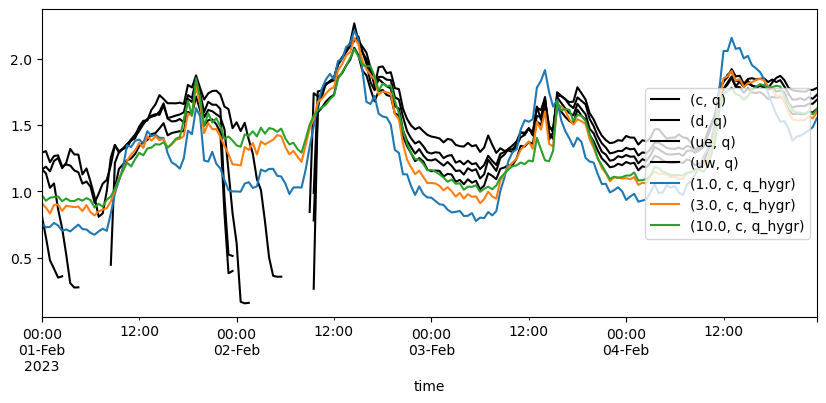

In [37]:
import matplotlib.pyplot as plt

ax = abs_hum_field_df[3].loc['20230201': '20230204'].plot(figsize=(10,4), color='black', legend=False)
(1000*abs_hum_field_hygr_df.loc['20230201': '20230204']).plot(figsize=(10,4), ax=ax)
plt.legend(loc='right')

# 3D Differential Solution

## Calculate interpolated fields (3D)

In [ ]:
HEIGHTS = [3,10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df = df[HEIGHTS]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_repeated = xxx.loc[xxx.index.repeat(len(data_df))]
instrument_loc_limited_heights_repeated.index = data_df.index
instrument_loc_limited_heights_repeated
data_df = data_df.join(instrument_loc_limited_heights_repeated)

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx, yy, zz = np.meshgrid(
    np.linspace(instrument_loc_limited_heights.x.min(), instrument_loc_limited_heights.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.y.min(), instrument_loc_limited_heights.y.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.z.min(), instrument_loc_limited_heights.z.max(), VERT_GRID_SPACING)
)
spacing_x = np.diff(xx[0,:,0]).mean()
spacing_y = np.diff(yy[:,0,0]).mean()
spacing_z = np.diff(zz[0,0,:]).mean()
points = np.transpose(np.vstack((instrument_loc_limited_heights.x, instrument_loc_limited_heights.y, instrument_loc_limited_heights.z)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp = data_df.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_interp = data_df.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_interp = data_df.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp = data_df.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_q__interp = data_df.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_q__interp = data_df.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp = data_df.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
r_interp = data_df.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
q_interp = data_df.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)

### PLOT: Example of a 3d interpolated wind field

In [ ]:
import matplotlib.pyplot as plt
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(
    xx[::5,::5,::2], 
    yy[::5,::5,::2],
    zz[::5,::5,::2],
    u_interp[100][::5,::5,::2],
    v_interp[100][::5,::5,::2], 
    w_interp[100][::5,::5,::2],
    label='interpolated'
)
# plt.quiver(
#     data_df.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'z')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'w')].values.astype('float'),
#     label='measured',
#     color='red'
# )

## Calculate terms (3D)

Calculate advective terms in both the Paw U form

$u \rho \dfrac{\partial s}{\partial x} + v \rho \dfrac{\partial s}{\partial y} + w \rho \dfrac{\partial s}{\partial z}$

and in the Sun form

$u \dfrac{\partial q}{\partial x} + v \dfrac{\partial q}{\partial y} + w \dfrac{\partial q}{\partial z}$

and also calculate the turbulent flux divergence terms (same for Paw U and Sun)

$\dfrac{\partial \overline{u'q'}}{\partial x} + \dfrac{\partial \overline{v'q'}}{\partial y} + \dfrac{\partial \overline{w'q'}}{\partial z}$

In [ ]:
# Create dataframe with grids of interpolated data
u_interp.name = 'u'
v_interp.name = 'v'
w_interp.name = 'w'
u_q__interp.name = 'u_q_'
v_q__interp.name = 'v_q_'
w_q__interp.name = 'w_q_'
rho_interp.name = 'rho'
r_interp.name = 'r'
q_interp.name = 'q'

fields_df = pd.DataFrame(u_interp).join(
    v_interp
).join(
    w_interp
).join(
    u_q__interp
).join(
    v_q__interp
).join(
    w_q__interp
).join(
    rho_interp
).join(
    r_interp
).join(
    q_interp
)

In [ ]:
# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
# means of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
# medians of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_3d = fields_df.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmean(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmedian(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmedian(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
    )
    ,
    axis = 1
)
advective_terms_3d = pd.DataFrame(
    [[a, b, c, d, e, f, g, h, i, j, k, l] for a,b,c,d,e,f,g,h,i,j,k,l in advective_terms_3d.values], 
    columns=[
        'lateral_advection_pawu (mean)',
        'vertical_advection_pawu (mean)',
        'lateral_advection_sun (mean)',
        'vertical_advection_sun (mean)',
        'lateral_turb_flux_div (mean)',
        'vertical_turb_flux_div (mean)',
        
        'lateral_advection_pawu (median)',
        'vertical_advection_pawu (median)',
        'lateral_advection_sun (median)',
        'vertical_advection_sun (median)',
        'lateral_turb_flux_div (median)',
        'vertical_turb_flux_div (median)',
    ]
)
advective_terms_3d.index = fields_df.index

In [ ]:
advective_terms_3d = advective_terms_3d*7
advective_terms_3d

## Examine results

In [ ]:
mean_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'mean' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

median_chart = (alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c and 'median' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)).resolve_scale(color='independent')

(mean_chart & median_chart).resolve_scale(y='shared', x='shared')

In [ ]:
alt.Chart(
    advective_terms_3d.loc['20230201': '20230205'].reset_index()
).transform_fold(
    list(advective_terms_3d.columns)
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    # .scale(domain=[0,0.02], clamp=True),
    alt.Color('key:N')
)

# 2D Differential Solution

## 3m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [3]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  means of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
#  medians of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_3m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_3m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_3m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_3m.index = fields_df_2d.index

### PLOT: Example of a 2d interpolated wind field

In [ ]:
import matplotlib.pyplot as plt
plt.quiver(
    xx_2d[::4], 
    yy_2d[::4],
    u_interp_2d[100][::4],
    v_interp_2d[100][::4], 
    label='interpolated'
)
plt.quiver(
    data_df_2d.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
    label='measured',
    color='red'
)

## 10m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_10m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_10m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_10m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_10m.index = fields_df_2d.index

## Average the two planes

In [ ]:
advective_terms_2d_3m

In [ ]:
advective_terms_2d_10m

In [ ]:
advective_terms_2d = (advective_terms_2d_3m + advective_terms_2d_10m)/2
advective_terms_2d = advective_terms_2d*7

## Examine results

In [ ]:
alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

# Surface Integral Solution

## Define area of triangular prism faces

In [ ]:
from metpy.units import units

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
CV_HEIGHT = 7*units('m')
VOLUME = A4*CV_HEIGHT
A1, A2, A3, A4, A5, VOLUME

## Define normal vectors to the triangular prism faces

In [ ]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

In [ ]:
import geopandas as gpd
instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

## Calculate storage term

In [ ]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [ ]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

In [ ]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

## Calculate advective flux

In [ ]:
advective_flux_3m_ue = wind_field_df[3]['ue'].multiply(
    abs_hum_field_df[3]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_ue = wind_field_df[10]['ue'].multiply(
    abs_hum_field_df[10]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_uw = wind_field_df[3]['uw'].multiply(
    abs_hum_field_df[3]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_uw = wind_field_df[10]['uw'].multiply(
    abs_hum_field_df[10]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_d = wind_field_df[3]['d'].multiply(
    abs_hum_field_df[3]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_d = wind_field_df[10]['d'].multiply(
    abs_hum_field_df[10]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_c = wind_field_df[3]['c'].multiply(
    abs_hum_field_df[3]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_c = wind_field_df[10]['c'].multiply(
    abs_hum_field_df[10]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_flux = 0.25*(
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face1_avg_v_flux = 0.25*(
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face2_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face2_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face3_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq']
)

face3_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq']
)

face4_avg_w_flux = 0.25*(
    advective_flux_10m_ue['wq'] + advective_flux_10m_uw['wq'] + 
    advective_flux_10m_c['wq'] + advective_flux_10m_d['wq']
)

face5_avg_w_flux = - 0.25*(
    advective_flux_3m_ue['wq'] + advective_flux_3m_uw['wq'] + 
    advective_flux_3m_c['wq'] + advective_flux_3m_d['wq']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1.m + 
    face2_projected_adv_flux*A2.m + 
    face3_projected_adv_flux*A3.m
) / VOLUME.m

total_vertical_adv_divergence = (face4_avg_w_flux*A4 + face5_avg_w_flux*A5)  / VOLUME

## Calculate turbulent flux divergence

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face1_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face2_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face2_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face3_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_']
)

face3_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_']
)

face4_avg_w_turb_flux = 0.25*(
    turb_flux_field_df[10]['ue']['w_h2o_'] + turb_flux_field_df[10]['uw']['w_h2o_'] + 
    turb_flux_field_df[10]['c']['w_h2o_'] + turb_flux_field_df[10]['d']['w_h2o_']
)

face5_avg_w_turb_flux = - 0.25*(
    turb_flux_field_df[3]['ue']['w_h2o_'] + turb_flux_field_df[3]['uw']['w_h2o_'] + 
    turb_flux_field_df[3]['c']['w_h2o_'] + turb_flux_field_df[3]['d']['w_h2o_']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_turb_flux,
    face1_avg_v_turb_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_turb_flux,
    face2_avg_v_turb_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_turb_flux,
    face3_avg_v_turb_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_turb_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_turb_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_turb_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_turb_divergence = (
    face1_projected_turb_flux*A1.m + 
    face2_projected_turb_flux*A2.m + 
    face3_projected_turb_flux*A3.m
) / VOLUME.m

total_vertical_turb_divergence = (face4_avg_w_turb_flux*A4 + face5_avg_w_turb_flux*A5)  / VOLUME

## Examine results

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_turb_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(w_h2o_):Q')
    )
).properties(title='Vertical Turb. Flux Divergence') | (
    alt.Chart(
        pd.DataFrame(total_lateral_turb_divergence).reset_index().assign(time=total_vertical_turb_divergence.index).rename(columns={0:'u_q_'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(u_q_):Q')
    )
).properties(title='Lateral Turb. Flux Divergence')).resolve_scale(y='shared', x='shared')

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(wq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(wq):Q')
    )
).properties(title='Vertical Advection') | (
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(uq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(uq):Q')
    )
).properties(title='Lateral Advection')).resolve_scale(y='shared', x='shared')

# 1D Differential Solution

## Calculate horizontal advection (using two-point solution to derivative)

### Using KPS and Annex Hygrometer measurements

In [99]:
# Calculate horizontal advection 
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = abs_hum_field_hygr_df[3]['c']['q_hygr'].rename('kps')
kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps'] if row['direction'] == 'down' else row['kps'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx'] = kps_lateral_simple_df['ds'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['lateral_advection'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx']
from metpy.units import units

kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * kps_lateral_simple_df['kps'].diff() * units('g/g') / (30*60*units('seconds'))
kps_lateral_simple_df.dropna()

,annex,kps,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection,ds/dt
time,,,,,,,,,,,,
2022-11-01 01:00:00,0.002794,0.002738,304.689484,1.582793,938.457131,-0.000696,down,0.000056,400,1.405851e-07,0.000209,-4.130262e-05
2022-11-01 01:30:00,0.002810,0.002737,310.308075,2.225387,938.780129,-0.000560,down,0.000073,400,1.837235e-07,0.000384,-6.356941e-07
2022-11-01 02:00:00,0.002753,0.002721,313.789551,2.548928,939.538717,-0.001403,down,0.000032,400,7.935829e-08,0.000190,-8.261951e-06
2022-11-01 02:30:00,0.002763,0.002702,310.939148,2.603606,941.148043,-0.000559,down,0.000061,400,1.522928e-07,0.000373,-9.844330e-06
2022-11-01 03:00:00,0.002741,0.002701,309.363892,2.569098,939.907968,-0.001485,down,0.000041,400,1.018560e-07,0.000246,-7.652084e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:00:00,0.003560,0.003550,293.502136,3.764714,860.515952,0.152427,up,-0.000010,400,-2.449440e-08,-0.000079,2.266744e-05
2023-06-19 15:30:00,0.003263,0.003308,319.240662,3.109800,860.401869,0.147933,down,-0.000045,400,-1.114288e-07,-0.000298,-1.158460e-04
2023-06-19 16:00:00,0.003561,0.003714,314.099487,4.079733,860.601842,0.128144,down,-0.000153,400,-3.823352e-07,-0.001342,1.942859e-04


### Using KPS Irga measurements

In [100]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_lateral_simple_irga_df = pd.DataFrame(upwind_s)
kps_lateral_simple_irga_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)


# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df[
    ((kps_lateral_simple_irga_df.dir_10m_c >= 100) & (kps_lateral_simple_irga_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_irga_df.dir_10m_c >= 300) & (kps_lateral_simple_irga_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_lateral_simple_irga_df['direction'] = kps_lateral_simple_irga_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_irga_df['ds'] = kps_lateral_simple_irga_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_lateral_simple_irga_df['dx'] = 32
kps_lateral_simple_irga_df['ds/dx'] = kps_lateral_simple_irga_df['ds'] / kps_lateral_simple_irga_df['dx']

kps_lateral_simple_irga_df

kps_lateral_simple_irga_df['lateral_advection_irga'] = kps_lateral_simple_irga_df['spd_3m_c'] * kps_lateral_simple_irga_df['rho'] * kps_lateral_simple_irga_df['ds/dx']
kps_lateral_simple_irga_df

,upwind_s,downwind_s,dir_10m_c,spd_3m_c,rho,w_h2o__3m_c,direction,ds,dx,ds/dx,lateral_advection_irga
time,,,,,,,,,,,
2022-11-01 00:30:00,0.003000,0.002884,317.077209,2.358271,933.485270,-0.000107,down,-0.000116,32,-0.000004,-0.007971
2022-11-01 01:00:00,0.002974,0.002860,304.689484,1.582793,938.457131,-0.000696,down,-0.000114,32,-0.000004,-0.005273
2022-11-01 01:30:00,0.002941,0.002832,310.308075,2.225387,938.780129,-0.000560,down,-0.000110,32,-0.000003,-0.007157
2022-11-01 02:00:00,0.002931,0.002819,313.789551,2.548928,939.538717,-0.001403,down,-0.000113,32,-0.000004,-0.008440
2022-11-01 02:30:00,0.002915,0.002805,310.939148,2.603606,941.148043,-0.000559,down,-0.000110,32,-0.000003,-0.008409
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 14:00:00,0.003749,0.003851,321.372681,4.648945,862.134695,0.172137,down,0.000102,32,0.000003,0.012833
2023-06-19 15:30:00,0.003534,0.003761,319.240662,3.109800,860.401869,0.147933,down,0.000226,32,0.000007,0.018937
2023-06-19 16:00:00,0.003955,0.004059,314.099487,4.079733,860.601842,0.128144,down,0.000104,32,0.000003,0.011424


## Calculate vertical advection

### Simple two-point solution to the derivative

#### 3 to 10m

In [101]:
# kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
#     '20221101': '20230620'
# ]['value'].rename('mixingratio_3m_c')
# kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time').loc[
#     '20221101': '20230620'
# ]['value'].rename('mixingratio_10m_c')
# kps_vert_simple_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
# kps_vert_simple_df['ds'] = kps_vert_simple_df['mixingratio_10m_c'] - kps_vert_simple_df['mixingratio_3m_c']
# kps_vert_simple_df['dz'] = 7
# kps_vert_simple_df['ds/dz'] = kps_vert_simple_df['ds'] / kps_vert_simple_df['dz']

# kps_vert_simple_df = kps_vert_simple_df.join(
#     tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
# ).join(
#     1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
# ).join(
#     tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
# )
# kps_vert_simple_df['vertical_advection_simple'] =  kps_vert_simple_df['w'] * kps_vert_simple_df['rho'] * kps_vert_simple_df['ds/dz']

#### 3 to 20m

In [102]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_20m = tidy_df.query("variable == 'mixingratio_20m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_20m_c')
kps_vert_simple_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_20m)
kps_vert_simple_df['ds'] = kps_vert_simple_df['mixingratio_20m_c'] - kps_vert_simple_df['mixingratio_3m_c']
kps_vert_simple_df['dz'] = 17
kps_vert_simple_df['ds/dz'] = kps_vert_simple_df['ds'] / kps_vert_simple_df['dz']

kps_vert_simple_df = kps_vert_simple_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)
kps_vert_simple_df['vertical_advection_simple'] =  kps_vert_simple_df['w'] * kps_vert_simple_df['rho'] * kps_vert_simple_df['ds/dz']

### Numerical multi-point solution to the derivative

#### 3 to 10m

In [103]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

kps_vert_complex_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection_complex': vert_adv_ls
})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3858675350.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3858675350.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3858675350.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/3858675350.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame i

#### 3 to 20m

In [104]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

kps_vert_complex_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection_complex': vert_adv_ls
})

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1804544975.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 20]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_30590/1804544975.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame i

In [105]:
# if using vertical advection calculations up to 10m
# advection_1d_fluxdensity_df = kps_vert_simple_df[['w_h2o__3m_c']].join(
#     kps_lateral_simple_df[['ds/dt']]*7
# ).join(
#     kps_vert_simple_df[['vertical_advection_simple']]*7
# ).join(
#     kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]*7
# ).join(
#     kps_lateral_simple_df[['lateral_advection']]*7
# ).join(
#     kps_lateral_simple_irga_df['lateral_advection_irga']*7
# )

# if using vertical advection calculations up to 20m
advection_1d_fluxdensity_df = kps_vert_simple_df[['w_h2o__3m_c']].join(
    kps_lateral_simple_df[['ds/dt']]*7
).join(
    kps_vert_simple_df[['vertical_advection_simple']]*17
).join(
    kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]*17
).join(
    kps_lateral_simple_df[['lateral_advection']]*7
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']*7
)

## Examine results

In [106]:
import datetime as dt

src = advection_1d_fluxdensity_df.groupby([
    advection_1d_fluxdensity_df.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250)

daily_median_cycle

alt.Chart(...)

In [119]:
import datetime as dt
src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(tgrad_stable_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

stable_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250)

src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(tgrad_neutral_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

neutral_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250)

src = advection_1d_fluxdensity_df[
    (advection_1d_fluxdensity_df.index.isin(tgrad_unstable_times))
    &
    (advection_1d_fluxdensity_df.index.isin(nobs_times))
]
src = src.groupby([
    src.index.floor('30T').time
]).median().reset_index()
src['time'] = src['index'].apply(lambda t: dt.datetime.combine(dt.date(2023,1,1), t))

unstable_daily_median_cycle = alt.Chart(
    src.reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection',
    'ds/dt'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Median of water vapor flux density (g/m^2/s)'),
    alt.Color('key:N')
).properties(height = 250, width=250)

(
    stable_daily_median_cycle.properties(title='stable') 
    | neutral_daily_median_cycle.properties(title='neutral') 
    | unstable_daily_median_cycle.properties(title='unstable')
).resolve_scale(y='shared', x='shared', color='shared')


alt.HConcatChart(...)

In [88]:
src = advection_1d_fluxdensity_df.loc['20221221': '20221223'][[
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

dec_casestudy = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N', legend=None)
    ).properties(width=200, height = 100) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221': '20221223'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=200, height = 100)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

src = advection_1d_fluxdensity_df.loc['20230201': '20230203'][[
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

feb_casestudy = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']).title(None),
        alt.Color('key:N', legend=None)
    ).properties(width=200, height = 100) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230201': '20230203'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']).title(None),
        alt.StrokeDash('height:N', legend=None)
    ).properties(width=200, height = 100)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

src = advection_1d_fluxdensity_df.loc['20230416': '20230417'][[
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]].reset_index()

april_casestudy = (
    alt.Chart(src).transform_fold([
        'w_h2o__3m_c',
        'vertical_advection_simple',
        # 'vertical_advection_complex',
        'lateral_advection',
        'ds/dt'
    ]).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Water vapor flux density', '(g/m^2/s)']).title(None),
        alt.Color('key:N')
    ).properties(width=200, height = 100) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230416': '20230417'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']).title(None),
        alt.StrokeDash('height:N')
    ).properties(width=200, height = 100)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

(dec_casestudy | feb_casestudy | april_casestudy).display(renderer='svg')

alt.HConcatChart(...)

In [89]:
daily_median_cycle.display(renderer='svg')

alt.Chart(...)

In [ ]:
advection_1d_fluxdensity_df.loc['20230401': '20230404'][[
    'w_h2o__3m_c',
    'vertical_advection_simple',
    # 'vertical_advection_complex',
    'lateral_advection'
]].plot()

In [ ]:


alt.Chart(
        advection_1d_df.loc['20230501': '20230519'].reset_index()
    ).transform_fold([
        'w_h2o__3m_c',
        # 'lateral_advection',
        # 'vertical_advection_complex',
        'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)').scale(domain=[0,0.1], clamp=True),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=800, height=200)

In [ ]:
advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index()

In [ ]:
snowdepth_df = pd.DataFrame({
    'kps snow depth': (tidy_df.query("variable=='SnowDepth_c'").set_index('time').loc['20230501': '20230530'].value*100),
    'annex snow depth': (annex_snowdepth_ds.to_dataframe().sort_index().loc['20230501': '20230530'].snow_depth).resample('30Min').mean()
})
snowdepth_df

In [ ]:
(
    alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230501': '20230530'].reset_index()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby=['key']
    ).mark_line().encode(
        alt.X('time:T').axis(labels=False).title(None),
        alt.Y('rolling_avg:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=700, height=200)
    &
    alt.Chart(snowdepth_df.reset_index()).mark_line().transform_fold([
        'kps snow depth', 'annex snow depth'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Snow depth (cm)'),
        alt.Color('key:N')
    ).properties(width=700, height=200)
).resolve_scale(x='shared', color='independent').display(renderer='svg')

In [ ]:
alt.Chart(
    advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230630'].reset_index()
).transform_fold([
    'w_h2o__3m_c',
    'lateral_advection',
    # 'vertical_advection_complex',
    # 'lateral_advection_irga'
]).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-0,0],
    groupby=['key']
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('rolling_avg:Q').title('Water vapor flux density (g/m^2/s)'),
    alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
).properties(width=700, height=200)

In [ ]:


alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index().dropna()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

In [ ]:


alt.Chart(
        advection_1d_df.assign(lateral_advection = advection_1d_df.lateral_advection*7).loc['20230601': '20230619'].reset_index().dropna()
    ).transform_fold([
        'w_h2o__3m_c',
        'lateral_advection',
        # 'vertical_advection_complex',
        # 'lateral_advection_irga'
    ]).mark_line().encode(
        alt.X('time:T'),
        alt.Y('value:Q').title('Water vapor flux density (g/m^2/s)'),
        alt.Color('key:N').sort(['w_h2o__3m_c', 'kps-annex lateral advection'])
    ).properties(width=600, height=200)

# Data exploration

## Compare IRGA and Hygrometer measurements

In [ ]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

In [ ]:
import math 

src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values

from sklearn.metrics import r2_score
meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') | r2_plot(6, 'June')
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)

## Examine daily cycles in vertical wind speed, hygrometer humidity, and irga humidity

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('height:O').scale(scheme='sinebow'),
    alt.Row('tower:N'),
    tooltip='height',
).properties(width = 200, height = 200, title='Vertical wind speed') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['mixingratio_2m_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'mixingratio_10m_c', 'mixingratio_15m_c', 'mixingratio_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Water vapor mixing ratio (g/g)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='Hygrometer mixing ratio') | alt.Chart(
    tidy_df[tidy_df.variable.isin(['h2o_2m_c', 'h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c', 'h2o_20m_c',])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Absolute humidity (g/m^3)').scale(zero=False),
    alt.Color('height:O'),
    tooltip='height',
).properties(width = 200, height = 200, title='IRGA absolute humidity')

In [ ]:
import altair as alt
alt.Chart(
    tidy_df[tidy_df.variable.isin([
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    ])]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('value:Q'),
    alt.Color('variable')
)